강의_6기_AI응용_4차시_06_CamShift 트래킹.ipynb

Camshift
- Meanshift의 업그레이드 버전
- 객체 크기가 바뀌거나 회전해도 추적가능
- <> meanshift 고정박스

In [1]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab 환경에서 이미지 표시를 위한 함수 임포트
import time # 출력 속도 조절을 위한 time 모듈 임포트
import matplotlib.pyplot as plt

# --- 1. 변수 초기 설정 ---
roi_hist = None # 추적 객체 히스토그램 저장 변수
win_name = 'CamShift Tracking' # 화면 표시 창 이름 (Colab에서는 디버깅용)

# CamShift에 필요한 초기 추적 영역 좌표를 전역으로 초기화
# NOTE: 이 값을 수정하여 추적할 객체의 초기 위치와 크기를 설정할 수 있습니다.
# (x, y) = 시작 좌표, (w, h) = 너비, 높이
x, y, w, h = 200, 200, 100, 100

# CamShift 중지 요건 (Termination Criteria)
# (오차(EPS) 또는 반복 횟수(COUNT) 중 하나라도 충족되면 중지)
termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

In [2]:
# --- 2. 비디오 캡처 설정 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'top-down.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = 'top-down.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
delay = int(1000/24) # 딜레이 설정 (약 41ms)

if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

# Colab 환경을 위해 프레임 처리 개수를 제한하고 출력 주기를 설정합니다.
frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"CamShift 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

CamShift 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...


In [3]:
# 3. 첫 프레임에서 ROI 히스토그램 등록
ret, frame = cap.read()
if not ret:
    print("오류: 첫 프레임을 읽을 수 없습니다.")
    exit()

if w > 0 and h > 0: # 유효한 ROI 설정된 경우에만 히스토그램 계산
    # 3-1.초기 추적대상 영역(ROI) 추출, HSV 변경
    roi = frame[y:y+h, x:x+w]
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    # 3-2. ROI 히스토그램 계산 시 노이즈 픽셀제외(마스크 생성)
    mask = cv2.inRange(roi_hsv, np.array((0.,50.,50.)), np.array((180.,255.,255.)))

    # 3-3. ROI의 (h)의 히스토그램 계산, 정규화
    roi_hist = cv2.calcHist([roi], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
    print(f'초기 추적영역 설정완료 x = {x}, y = {y}, w = {w}, h = {h}')
else:
    print('오류')
    exit()

초기 추적영역 설정완료 x = 200, y = 200, w = 100, h = 100


노이즈 필터링 마스크
- 마스크 역할 : HSV 범위 필터링
- 하한(0., 50., 50.) 
    - h=0 : 모든 색상
    - s=50, v=50 : 노이즈 제거
        - 추적 안 됨
        - s < 50 : 색이 거의 없는 회색
        - v < 50 : 매우 어두움

- 상한(180., 255., 255.)

- H(색상) : 0~179도 (OpenCV 인식범위) <> 일반적으로 0-360
- S(채도) : 0-255 (OpenCV 인식범위) <> 일반적으로 0-1
- V(명도) : 0-255 (OpenCV 인식범위) <> 일반적으로 0-1

마스크 예제
mask = [100, 30, 40] -> 검출 0
mask = [120, 200, 200] -> 다 검출

프레임 0 추적 중...


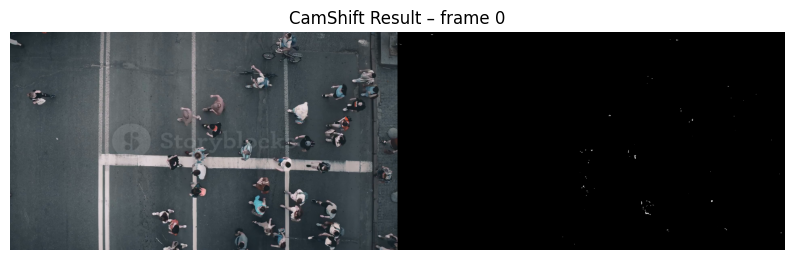

프레임 20 추적 중...


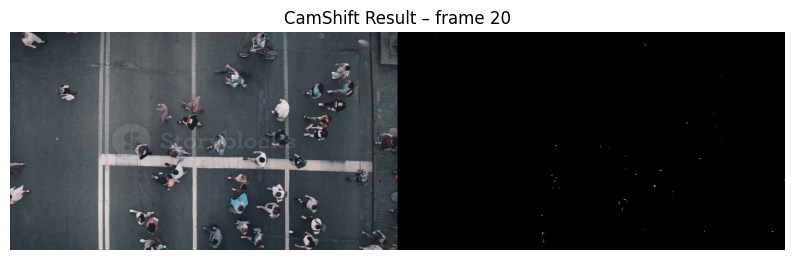

프레임 40 추적 중...


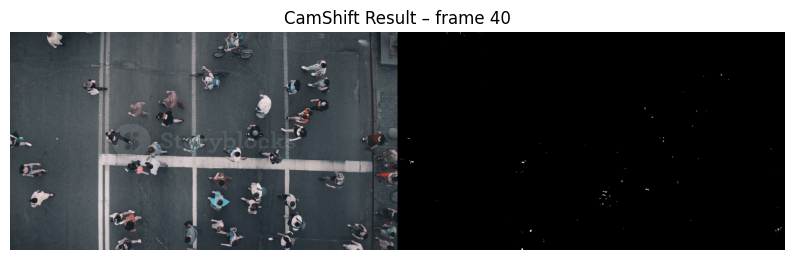

프레임 60 추적 중...


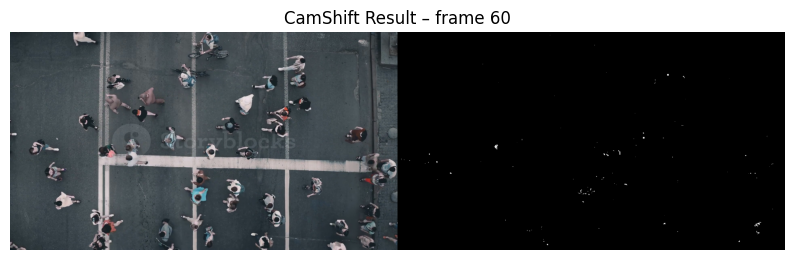

프레임 80 추적 중...


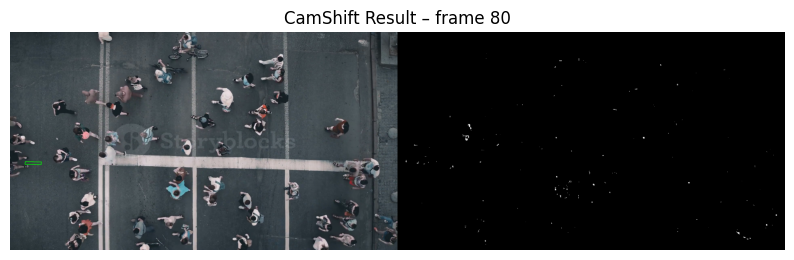

프레임 100 추적 중...


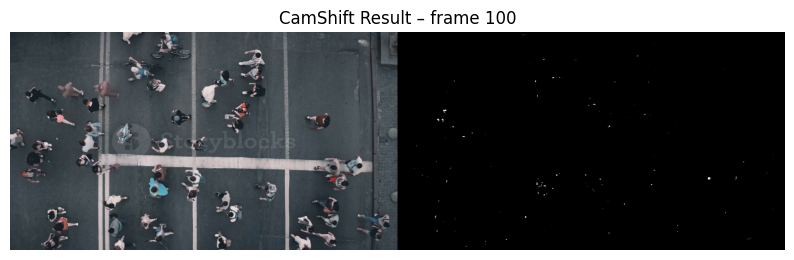

프레임 120 추적 중...


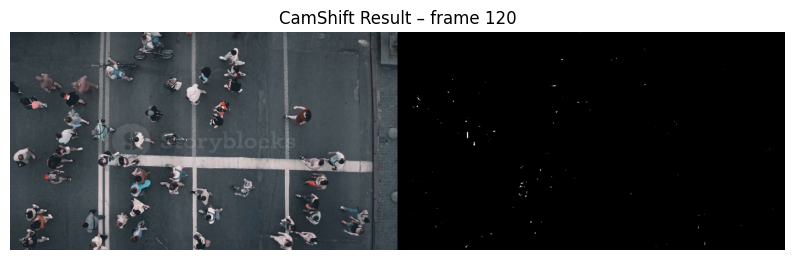

프레임 140 추적 중...


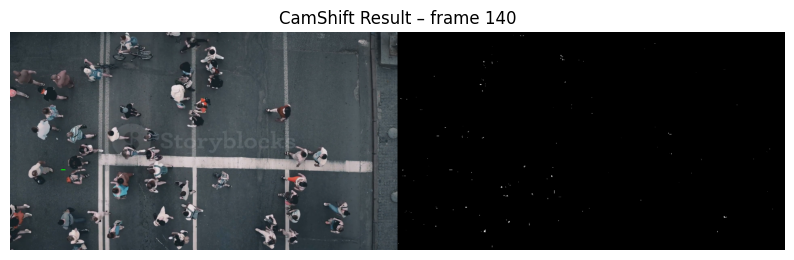

출력완료


In [4]:
# --- 4. 비디오 처리 루프 ---
while cap.isOpened() and frame_count < MAX_FRAMES_TO_PROCESS:
    ret, frame = cap.read()
    if not ret:
        break

    img_draw = frame.copy() # 원본 프레임 복사

    # --- 4-1. 추적 진행 ---
    if roi_hist is not None:
        # 1. 전체 영상 BGR -> HSV 컬러 변환
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # 2. 마스크 생성: 채도(S)와 명도(V)가 낮은 픽셀을 제외하여 노이즈 제거
        target_mask = cv2.inRange(hsv, np.array((0., 50., 50.)), np.array((180., 255., 255.)))

        # 3. Back Projection (역투영)
        # 전체 영상에 대해서 ROI 히스토그램을 역투영
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180],1)
        # [hsv] : 입력 이미지, 히스토그램을 적용할 대상 (전체 비디오 프레임(이미지))

        # 4. 역투영 결과에 마스크 곱하여 노이즈 영역 확률을 0으로 만듦
        dst = dst * target_mask

        # 5. 마스크 적용된 역투영맵과 이전 추적 위치로 camshift 추적 실행
        ret, track_window = cv2.CamShift(dst, (x, y, w, h), termination)
        # 공분산, 고유값분해. 장축단축 길이 조절. 회전각도는 고유벡터.
        # ret : rotatedRect(회전된 사각형) 중심점(cx, cy)과 크기(w,h), 회전각(angle)
        # track_window : 일반 bbox (x, y, w, h) -> 다음 프레임 입력으로 들어감

        # 6. 다음 프레임을 위한 track_window 업데이트
        x, y, w, h = track_window

        # 7. 새로운 위치에 사각형 표시
        pts = cv2.boxPoints(ret) # 회전 정보를 4개의 꼭지점 좌표로 변환
        pts = np.int32(pts)
        # True : 폐곡선 그림. 끝점과 시작점 연결
        cv2.polylines(img_draw, [pts], True, (0,255,0), 2)
        
        # 8. 컬러영상과 역투영 영상을 통합출력
        dst_bgr = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
        result = np.hstack((img_draw, dst_bgr))
    else:
        cv2.putText(
            img_draw, 
            "Tracking failure detected", 
            (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (0, 0, 255), 
            cv2.LINE_AA
            )
        result = img_draw
        
    # 특정 간격의 프레임만 표시
    if frame_count % DISPLAY_EVERY_N_FRAMES == 0:
        print(f'프레임 {frame_count} 추적 중...')
        # cv2_imshow(result) # 추적 결과 프레임 표시

        plt.figure(figsize=(10, 5))                     # 가로·세로 비율 조절
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
        plt.title(f'CamShift Result – frame {frame_count}')
        plt.axis('off')                                 # 축 숨김
        plt.show()   

        time.sleep(1) # 잠시 대기

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

print('출력완료')
